<center><h1> Modelling, Simulation and Optimisation Project</h1></center>

<center><h2> Ashish Rawat </h2></center>
<center><h3> X18185801 </h3></center>




<h1>Table of Contents<span class="tocSkip"></span></h1>

<div class="toc"><ul class="toc-item"><li><span><a href="#Load-Libraries" data-toc-modified-id="Load-Libraries-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load Libraries</a></span></li><li><span><a href="#Prepare-Data" data-toc-modified-id="Preapre-Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Prepare Data</a></span></li><li><span><a href="#Data-Transformation" data-toc-modified-id="Data-Transformation-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Data Transformation</a></span></li><li><span><a href="#Trains" data-toc-modified-id="Trains-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Trains</a></span></li><li><span><a href="#Network-Node" data-toc-modified-id="Network-Node-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Network Node</a></span></li><li><span><a href="#Depot" data-toc-modified-id="Depot-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Depot</a></span></li><li><span><a href="#Stations" data-toc-modified-id="Stations-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Stations</a></span></li><li><span><a href="#Network" data-toc-modified-id="Network-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Network</a></span></li><li><span><a href="#Utilities" data-toc-modified-id="Utilities-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Utilities</a></span></li><li><span><a href="#Testing-Simulation" data-toc-modified-id="Testing-Simulation-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Testing Simulation</a></span></li><li><span><a href="#Simulation" data-toc-modified-id="Simulation-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>Optimisation</a></span></li>
    
    
</ul></div>

## Load Libraries

In [1972]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as stats
import math
import numpy as np
import random
import simpy
import simpy.events as evt
from numpy import random

## Prepare data 

The Dataset used for this project (HS2Line) is formed of data given in  the problem statement.
And the value for distance between London Euston to London Old Oak Common and Birmingham Interchange and Birmingham Curszon Street is derived using the distance given for London Old Oak Common to Birmingham Interchange.

Distance between London Old Oak Common and Birmingham Interchange, d<sub>L-B</sub> = 145 kms (145000 m)<br>
Acceleration of train, a = 0.72 m/s<sup>2</sup> <br>
Maximun velocity, v = 300 km/h (83.3 m/s) <br>
Time taken to achieve max velocity, t<sub>v</sub> = 115.7 s <br>
Distance travelled while t<sub>v</sub>, d<sub>v</sub> = 4820 m <br>
Time taken to deaccelerate from max velocity to 0, t<sub>0</sub> = 231.4 s <br>
Distance travelled while t<sub>0</sub>, d<sub>0</sub> = 9640 m <br>

Hence, <br>
Total time taken for train from 0 to max velocity and max velocity to 0, t<sub>t</sub> = 115.7 + 231.4 = 347.1 s<br>
Total distance covered in t<sub>t</sub>, d<sub>t</sub> = 4820 + 9640 = 14460 m <br> 

Since train starts from a station and stops at station it can be assumed from the given distance 145 km between London Old Oak Common and Birmingham Interchange 14.460 km is consumed to achieve max velocity and stop at station. For the remaining distance 'd' the train runs at full speed. 

It is given that train time between Birmingham Interchange and Birmingham Curszon is 9 mins (540 s). Out of 540 s train takes 347.1 s to start and stop, the remaining 192.9 the train travels at max velocity. Thus, distance between Birmingham Interchange and Birmingham Curszon can be calculated.

d<sub>B-B</sub> = 14460 + 192.9x83.3 = 30528.57 m 
For ease of calculation, d<sub>B-B</sub> = 31 km (31000 m)

Now, since the travel time between London Euston to London Old Oak Common is 5 mins (300 s), it indicates that the train never attains max velocity between these 2 stations. But let us assume for this case that train takes 100 s to accelerate and 200 accelerate, thus the distance between London Euston to London Old Oak Common is taken to be 15 km in the dataset. 

d<sub>L-L</sub> = 15000 m

In [1973]:
data=pd.read_csv('HS2Line.csv')
data

,Line,Direction,From,To,Drive Time,Distance
0,HS2,Birmingham,London Euston,London Old Oak Common,5,15
1,HS2,Birmingham,London Old Oak Common,Birmingham Interchange,31,145
2,HS2,Birmingham,Birmingham Interchange,Birmingham Curzon Street,9,31


## Data Transformation

The values of distance and the drive time present in the dataset are represented in kms and mins which are converted into meter and seconds.   


In [1974]:
data['Distance']=data['Distance'].apply(lambda x: int(x*1000))
data['Drive Time']=data['Drive Time'].apply(lambda x: int(x*60))

timeTo() function calculates the time taken by the train to travel a distance d. Depending upon the length d the function returns two travel times for the train. First, time taken by train to travel when it achieves max velocity and second the time taken by train when it does not achieve max velocity. For the latter case it is assumed that the train accelerates till halfway point and then deaccelerates to destination. 

In [1975]:
def timeTo(d):
    """
    A       acceleration, m/s²
    maxV    maximumum velocity, m/s
    d       distance, m
    return  time in seconds required to travel
    """
    A = 0.72 
    maxV = 83.3
    tA = 115.7 # time to accelerate to maxV
    tda= 231.4 # time to deaccelerate from maxV to 0
    dA = 14460  # distance traveled during acceleration from 0 to maxV and back to 0
    if (d < dA): # train never reaches full speed?
        return np.sqrt(4*d/A)   # time needed to accelerate to half-way point then decelerate to destination
    else:
        return tA+ tda+ (d-dA)/maxV   # time to accelerate to maxV plus travel at maxV plus decelerate to destination

setblocks() function generates a dataframe for b no. of signalling blocks passed as input. This way, for k values of blocks k dataframes are generated and utilised for simulation. b here represents the no. of signalling blocks between London Old Oak Common and Birmingham Interchange. Only the basis of b distance between stations are divided and timeTo() function is utilised to calculate 'Wait Drive Time'.

Wait Drive Time represents the actual time a train takes to cover a distance d of the track accelerating from 0 velocity and deaccelerating to halt. It is important to derive this feature to represent the travel time of train which have to wait for succeeding track or station. 

In [1976]:
def setblock(b):
    """
    For the given value of Blocks the setblock() generates a dataframe.
    The dataframe consists of b signalling blocks between London Old Oak Common and Birmingham Interchange
    """
    Blocks = b

    stations=data['From'].to_list()
    stations+=[data['To'].to_list()[-1]]

    block_data = pd.DataFrame(columns=['Line','From','To', 'Distance', 'Drive Time'])

    n = Blocks +3

    for i in range(3):
        if stations[i] == 'London Euston':
            block_data.at[i, 'From'] = 'London Euston'
            block_data.at[i, 'To'] = 'B0'
            block_data.at[i, 'Distance'] = data.at[i, 'Distance']//2
            block_data.at[i, 'Drive Time'] = data.at[i, 'Drive Time']//2
            block_data.at[i+1, 'From'] = 'B0'
            block_data.at[i+1, 'Distance'] = data.at[i, 'Distance']//2
            block_data.at[i+1, 'Drive Time'] = data.at[i, 'Drive Time']//2
        if stations[i] == 'London Old Oak Common':
            block_data.at[i, 'To'] = 'London Old Oak Common'
            block_data.at[i+1, 'From']= 'London Old Oak Common'
            for n in range(Blocks+1):
                block_data.at[i+1+n , 'To'] = f'B{1+n}'
                block_data.at[i+1+n , 'Distance'] = data.at[i, 'Distance']//(Blocks+1)
                block_data.at[i+1+n, 'Drive Time'] = data.at[i, 'Drive Time']//(Blocks+1)
                block_data.at[i+2+n, 'From'] = f'B{1+n}'
                block_data.at[i+2+n , 'Distance'] = data.at[i, 'Distance']//(Blocks+1)
                block_data.at[i+2+n, 'Drive Time'] = data.at[i, 'Drive Time']//(Blocks+1)
        if stations[i] == 'Birmingham Interchange':
            block_data.at[n+2, 'To'] = 'Birmingham Interchnage'
            block_data.at[n+3, 'From']= 'Birmingham Interchnage'
            block_data.at[n+3 , 'Distance'] = data.at[i, 'Distance']//3
            block_data.at[n+3, 'Drive Time'] = data.at[i, 'Drive Time']//3
            block_data.at[n+3, 'To']= f'B{Blocks+1}'
            block_data.at[n+4, 'From']= f'B{Blocks+1}'
            block_data.at[n+4, 'To']= f'B{Blocks+2}'
            block_data.at[n+4 , 'Distance'] = data.at[i, 'Distance']//3
            block_data.at[n+4, 'Drive Time'] = data.at[i, 'Drive Time']//3
            block_data.at[n+5, 'From']= f'B{Blocks+2}'
            block_data.at[n+5, 'To']= 'Birmingham Curzon Street'
            block_data.at[n+5 , 'Distance'] = data.at[i, 'Distance']//3
            block_data.at[n+5, 'Drive Time'] = data.at[i, 'Drive Time']//3

    block_data['Direction'] = 'L To B'
    block_data['Line'] = 'HS2'
    for i in range(len(block_data)):
        block_data.at[i, 'Wait Drive Time']=int(timeTo(block_data.at[i, 'Distance']))
    return block_data

Example of the dataframe generated 

In [1977]:
df = setblock(1)
df

,Line,From,To,Distance,Drive Time,Direction,Wait Drive Time
0,HS2,London Euston,B0,7500,150,L To B,204.0
1,HS2,B0,London Old Oak Common,7500,150,L To B,204.0
2,HS2,London Old Oak Common,B1,72500,930,L To B,1043.0
3,HS2,B1,Birmingham Interchnage,72500,930,L To B,1043.0
4,HS2,Birmingham Interchnage,B2,10333,180,L To B,239.0
5,HS2,B2,B3,10333,180,L To B,239.0
6,HS2,B3,Birmingham Curzon Street,10333,180,L To B,239.0


# Trains

The key entities for the simulation are the trains that move through the network.

In [1978]:
class Train(object):  
    def __init__(self, env, i, track):
        self.env = env
        self.no=i
        self.track = track
        self.tracing = False
    
    def getNo(self):
        return self.no

    def isTracing(self):
        return self.tracing
    
    def traceOn(self):
        self.tracing=True
    
    def trace_prefix(self, i):
        return f"{formattedSystemTime(self.env.now):s} " \
               "HS2" \
               f"[Train {i}]"
    
        
    def process(self):
        stations=self.track.getStations()
        here=stations[0]
        here_req=None
        yield self.env.timeout(here.dwellTime())
        
        for dest in stations[1:-1]:
            # The train is currently in station 'here'. The next station is 'dest'.
            # to depart for dest, the train requests access
            # to the track in the next staion.
                
            dest_req=dest.getTrack().request()
            start = self.env.now
            yield dest_req #requests 
                
            # if the train doesn't get immediate access, it continues waiting 
            # in the current station ('here').
            # if the train got access the train departs from 'here'for 'dest'
            stop = self.env.now
            diff = stop - start
            while (stop - start) != 0:
                dest.wait(self, dest)
                start= self.env.now
                yield dest_req
                stop = self.env.now
            
            here.dep(self, dest) 
           
            # Once the train has completely left the station, the train
            # will release the track of station ('here'). 
            # We assume that the train has left the station after 10 secs 
                
            yield self.env.timeout(5)
            if here != stations[0]:
                here.green(self)
            
            if here_req!=None:
                here.getTrack().release(here_req)

            # the train proceeds to drive to the next station ('dest')
            if diff == 0: # if there was no wait time for next track, time taken is drive time.
                yield self.env.timeout(dest.driveTime())
            else:
                yield self.env.timeout(dest.waitdriveTime())
            
            dest.arr(self)
                    
            yield self.env.timeout(dest.dwellTime())
                    
            here=dest
            here_req=dest_req
                
        # The train is now in the last station and has waited there already long
        # enough for all passengers to disembark. The destination is now the depot.
        depot=stations[-1]
        
        # Assuming that there is always space in the depot,
        # the train leaves for the depot:
        here.dep(self, depot)
                
        # Once the train has completely left the last station ('here'), 
        # the train will release the track of the last station. 
        # We assume that the train has left the station after 10 secs 
        yield self.env.timeout(10)
        if here_req!=None:
            here.getTrack().release(here_req)
                    
        # the train proceeds to drive into the depot
        yield self.env.timeout(depot.driveTime()-10)
                    
        # The train arrives at the depot and "checks in"
        depot.arr(self)    


# Network Node

NetworkNode is the base class of the subclasses like Depot and Station. 

In [1979]:
class NetworkNode:
    
    def __init__(self, env, location):
        self.env=env
        self.location=location
        self.line_name='HS2'
        self.direction='L To B'
        self.incidents=[]
        self.tracing=False
        self.arrTimes=[]
        self.depTimes=[]
    
    def setLine(self, line):
        self.line=line
        
    def isTracing(self):
        return self.tracing
    
    def traceOn(self):
        self.tracing=True
        
    def getArrivalTimes(self):
        return self.arrTimes
    
    def getDepartureTimes(self):
        return self.depTimes
        
    def trace_prefix(self, train):
        return f"{formattedSystemTime(self.env.now):s} " \
               f"{self.line_name:{Trace.lineNameLength()}s} " \
               f"[Train{train.getNo():2d}]" 
                  
    def arr(self, train):
        self.arrTime=self.env.now
        self.arrTimes+=[self.env.now]
        if Trace.notTracing(self.env.now): #Stops trace when notTracing is True
            return    
        elif self.line.isTracing():
            print(f"{self.trace_prefix(train):s} arr {self.loc():s}")        


    def dep(self, train, dest):
        self.depTimes+=[self.env.now]
        if Trace.notTracing(self.env.now): #Stops trace when notTracing is True
            return
        elif (self.line!=None and self.line.isTracing()) :
            print(f"{self.trace_prefix(train):s} dep {self.loc():s} for {dest.loc():s}")
                  
    def wait(self, train, dest):
        if Trace.notTracing(self.env.now): #Stops trace when notTracing is True
            return
        elif (self.line!=None and self.line.isTracing()) :
            print(f"{self.trace_prefix(train):s} Waiting {dest.loc():s} \x1b[31m\'Signal is Red'\x1b[0m")
                  
    def green(self, train):
        if Trace.notTracing(self.env.now): #Stops trace when notTracing is True
            return
        elif (self.line!=None and self.line.isTracing()) :
            print(f"{formattedSystemTime(self.env.now):s} {self.loc():s} \x1b[32m\'Signal is Green'\x1b[0m") 


# Depot

Depots are the staring and end points in the HS2 Line. Train is initiallised from the depot and the interval at which it is generated is formulated using the given waiting time. Depending upon the value of no. of trains per hour trains are intialized and at the end of the track depot stores the trains.

In [1980]:
class Depot(NetworkNode):
    def __init__(self, env, location):
        super().__init__(env, location)
        self.env=env
        self.location=location
        self.network= network
        self.line_name='HS2'
        self.direction='L To B'
        self.tracks=None

    def initialise(self, capacity):
        self.tracks=simpy.Container(self.env, capacity, init=capacity)
        
    def driveTime(self):
        return 20
    
    # the minimum dwell time is to allow for a proper break for the driver
    def dwellTime(self):
        return 0
        
    def dep(self, train, dest):
        # this requires a train being available in the depot
        super().dep(train, dest)

    def arr(self, train):
        # this puts the train back into the depot
        super().arr(train)
                
    def getTrack(self):
        return None
    
    def loc(self):
        return "(DEPOT)"
    
    def track_name(self):
        return self.location+"(DEPOT "+self.line_name+" "+self.direction+")"

# Stations 



Stations are blocks where passengers gets on and off the train. Poisson distribution is adopted for generating random numbers of passengers at an hour for a train station and out these generated a certain amount of passengers is formualted to boards the train while others wait for next train. 

It is assumed in this code, that Dwell time for trains at stations is 180 seconds.


In [1981]:
class Station(NetworkNode):
    def __init__(self, env, location):
        super().__init__(env, location)
        self.env=env
        self.location=location
        self.track=simpy.Resource(env, capacity=1)
        dd=pd.DataFrame(df[df['To']==location])
        if len(dd)==0:
            # This node is the first node of a track when coming out of the depot
            self.drive_time= 5 # drive time from depot to first station
            self.dwell_time= 180  # dwell time in first station
            self.wait_drive_time =10
        elif len(location) == 2:  # if it is a signalling block 
            self.drive_time=int(dd.iloc[0].at['Drive Time']) 
            # train would cover the distabce in drive time if there is no train utilising the next track.
            self.wait_drive_time=int(dd.iloc[0].at['Wait Drive Time']) # if their is delay it takes wait drive time.
            self.dwell_time= 0
        else:
            self.drive_time=int(dd.iloc[0].at['Drive Time'])
            self.wait_drive_time=int(dd.iloc[0].at['Wait Drive Time'])
            self.dwell_time=180 # Dwell time at stations are assumed to taken as 3 mins 

    def driveTime(self):
        return self.drive_time
    
    def waitdriveTime(self):
        return self.wait_drive_time
    
    def dwellTime(self):
        return self.dwell_time
   
    def getTrack(self):
        return self.track
    
    def loc(self):
        return self.location
    
    def track_name(self):
        return self.location

# Network

In [1982]:
class Line(object):
    def __init__(self, env, network, depot, stations):
        self.env=env
        self.network=network
        self.depot=depot
        self.stations=[depot]+stations+[depot]
        self.tracing=False
        self.tracingTrains=False
        self.tracingTrainNo=None
        for s in self.stations:
            s.setLine(self)
    
    def isTracing(self):
        return self.network.isTracing() or self.tracing
    
    # starts tracing the train in the given time span, from depot to depot.
    def traceOn(self, loc=None, train=None):
        if loc==None and train==None:
            self.tracing=True
        else:
            for s in self.stations:
                if s.loc()==loc:
                    s.traceOn()
            if train!=None:
                self.tracingTrains=True
                self.tracingTrainNo=train           
               
    def getStations(self): 
        return self.stations
    
        
    def setTiming(self, start, stop, t):
        self.start=start
        self.stop=stop
        self.trainperhour=t  # No. of trains per hour
        self.timing=1800//t  # Time are generated after this much time.
        self.depot.initialise(self.timing) # sets no. of trains in depot to be intialised.
    
    def process(self):
        yield self.env.timeout(self.start-self.env.now) # the line starts operating at 6am
        for i in range(self.trainperhour):  #i = no. of Trains
            tr=Train(self.env, i, self)
            if self.tracingTrains and self.tracingTrainNo==i:
                tr.traceOn()
            self.env.process(tr.process())
            yield self.env.timeout(self.timing) # waiting time between trains dependent on no. of trains per hour.

In [1983]:
def allStations(env): 
    '''
    This functions generates a lsit of all the stations in the HS2 Line 
    And passes it to the station class
    '''
    stations=df['From'].to_list()
    stations+=[df['To'].to_list()[-1]]
    return [ Station(env,s) for s in stations ]

In [1984]:
def allTracks(env, network):
    '''
    Sets the line for the train to cover. 
    Returns line objects of Line class
    '''
    stations= allStations(env)
    depot=Depot(env, stations[0].loc())

    l=Line(env, network, depot, stations)
    
    return l

In [1985]:
class Network(object):
    def __init__(self, start, stop, n):
        self.env=simpy.Environment()
        self.tracks=allTracks(self.env, self)
        self.start=parseTime(start)
        self.stop=parseTime(stop)
        self.trainperhour= n
        self.tracing=False
        
    def isTracing(self):
        return self.tracing

    
    def traceOn(self, line=None, direction=None, 
                loc=None, train=None, start=None, stop=None):
        if loc==None and train==None:
            Trace(start=start, stop=stop)
            self.tracing=True
        else:
            for t in self.tracks:
                Trace(line=line, direction=direction, start=start, stop=stop)
                if direction==None or t.self.direction==direction:
                    t.traceOn(loc=loc, train=train)
     
    
    # This functions sets the arrival and departure time from simulation into a dataframe.
    def getCumulativeData(self, line=None):
        total=0
        arr=[]
        dep=[]
        run_dep=len(self.tracks.stations[1].getDepartureTimes())
        run_arr=len(self.tracks.stations[-2].getArrivalTimes())
        n=max(run_dep, run_arr)-1
        total+=n
        for s in self.tracks.stations:
            if isinstance(s, Station):
                arr+=[s.arrTimes[i+1]-s.arrTimes[i] for i in range(len(s.arrTimes)-1)]
                dep+=[s.depTimes[i+1]-s.depTimes[i] for i in range(len(s.arrTimes)-1)]
        cd=pd.DataFrame(index=range(len(arr)))
        cd['ARR']=arr
        cd['DEP']=dep
        return cd

    
    def process(self):
        self.tracks.setTiming(self.start, self.stop, self.trainperhour)
        yield self.env.timeout(self.start-self.env.now) # the line starts operating at 6am
        self.env.process(self.tracks.process())
    
    def runSimulation(self):
        self.env.process(self.process())
        self.env.run()

# Utilities

In [1986]:
def formattedSystemTime(t):
    '''
    Converts system time into Real World time. 
    '''
    return f"{t//3600:02d}:{(t%3600)//60:02d}:{t%60:02d}"
        
def parseTime(s):
    '''
    Converts Real World time into system time.
    '''
    
    if isinstance(s, str):
        parts=s.split(':')
        if len(parts)>=2:
            hours=int(parts[0])
            minutes=int(parts[1])
            seconds=0 if len(parts)==2 else int(parts[2])
            return 3600*hours+60*minutes+seconds
    # any wrong formats will be passed through and may cause 
    # an error at a later stage
    return s

In [1987]:
class Trace:
    '''
    The class instance is initialised with Trace(line='...', dir='...')
    in the traceOn() method of the Network class
    static methods Trace.lineNameLength() and Trace.directionLength() will be called in the NetworkNode trace_prefix() method
    '''
    def __init__(self, line=None, direction=None, start=None, stop=None):
        Trace.__start = parseTime(start)
        Trace.__stop = parseTime(stop)
        Trace.__ll = len(line) if line!=None else \
                        len(df['Line'][0]) 
        
        Trace.__dl = len(direction) if direction!=None else \
                        len(df['Direction'][0])
        
    def lineNameLength():
        return Trace.__ll
    
    def directionLength():
        return Trace.__dl
    
    # this is a surpressing function and not an activating function
    def notTracing(systime):
        if Trace.__start!=None and systime<Trace.__start:
            return True
        if Trace.__stop!=None and systime>Trace.__stop:
            return True
        return False

# Testing Simulation

Here, for a specific block number and trains per hour simulation is being perfomred. <br>
No. of blocks = 7 <br>
No. of trains per hour = 10 <br>

In [1988]:
df = setblock(1)
network=Network("06:00", "23:00",5)
network.traceOn(line='HS2', start="06:00", stop="07:00")
network.runSimulation()

06:00:00 HS2 [Train 0] dep (DEPOT) for London Euston
06:00:10 HS2 [Train 0] arr London Euston
06:03:10 HS2 [Train 0] dep London Euston for B0
06:03:15 London Euston 'Signal is Green'
06:05:45 HS2 [Train 0] arr B0
06:05:45 HS2 [Train 0] dep B0 for London Old Oak Common
06:05:50 B0 'Signal is Green'
06:06:00 HS2 [Train 1] dep (DEPOT) for London Euston
06:06:10 HS2 [Train 1] arr London Euston
06:08:20 HS2 [Train 0] arr London Old Oak Common
06:09:10 HS2 [Train 1] dep London Euston for B0
06:09:15 London Euston 'Signal is Green'
06:11:20 HS2 [Train 0] dep London Old Oak Common for B1
06:11:25 London Old Oak Common 'Signal is Green'
06:11:45 HS2 [Train 1] arr B0
06:11:45 HS2 [Train 1] dep B0 for London Old Oak Common
06:11:50 B0 'Signal is Green'
06:12:00 HS2 [Train 2] dep (DEPOT) for London Euston
06:12:10 HS2 [Train 2] arr London Euston
06:14:20 HS2 [Train 1] arr London Old Oak Common
06:15:10 HS2 [Train 2] dep London Euston for B0
06:15:15 London Euston 'Signal is Green'
06:17:45 HS2 [Tr

### Extracting results of simulation

In [1913]:
cd = network.getCumulativeData()
cd.head()

,ARR,DEP
0,360,360
1,360,360
2,360,720
3,560,1120
4,360,360


### Arrival Time distribution

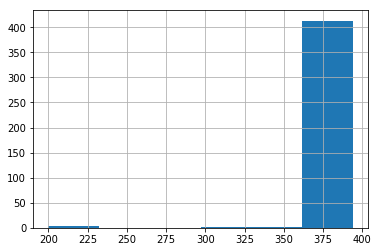

In [1989]:
cd['ARR'].hist(bins=6)

### Departure Time distribution

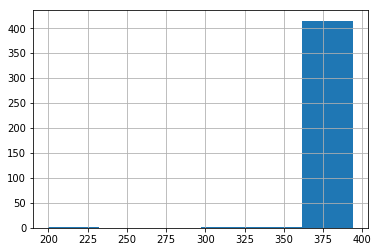

In [1990]:
cd['DEP'].hist(bins=6)

# Optimization

Now, that simulation process is operating properly simulations for values of  k and n can be generated.<br>
No. of signalling blocks, k ∈ {1, ..., 15} <br>
No. of trains per hour,  n ∈ {1, 2, 3, 4, 5, 6, 8, 10, 12, 15, 20}

### 1. Minimizing the overall travel time.

THe objective function for this case is minimizing the overall travelling time of the trains. 
It consists of Waiting time and time taken by train to arrive at a station.
Waiting Time is assumed from this equation, W<sub>t</sub>  = (0.5x60)/n, where n is the no. of trains per hour.

In [1969]:
list_n = []
list_k = []
list_tt = []
for k in range(1,16): # k represents the no. of blocks between London Old Oak Common to Birmingham Interchange.
    df= setblock(k)
    trainsph = [1, 2, 3, 4, 5, 6, 8, 10, 12, 15, 20]
    for n in trainsph: # n represents the no. of trains per hour.
        network=Network("06:00", "23:00", n)
        network.traceOn(line='HS2', start="06:00", stop="07:00")
        network.runSimulation()
        cd = network.getCumulativeData()
        Arrt= cd['ARR'].mean()
        wait= 1800//n
        Total_travel = Arrt + wait
        list_n.append(n)
        list_k.append(k)
        list_tt.append(Total_travel)
Train_data = pd.DataFrame({'Train per Hour': list_n, 'Signalling Blocks' : list_k, 'Overall Travel Time' : list_tt})

06:00:00 HS2 [Train 0] dep (DEPOT) for London Euston
06:00:10 HS2 [Train 0] arr London Euston
06:03:10 HS2 [Train 0] dep London Euston for B0
06:03:15 London Euston 'Signal is Green'
06:05:45 HS2 [Train 0] arr B0
06:05:45 HS2 [Train 0] dep B0 for London Old Oak Common
06:05:50 B0 'Signal is Green'
06:08:20 HS2 [Train 0] arr London Old Oak Common
06:11:20 HS2 [Train 0] dep London Old Oak Common for B1
06:11:25 London Old Oak Common 'Signal is Green'
06:26:55 HS2 [Train 0] arr B1
06:26:55 HS2 [Train 0] dep B1 for Birmingham Interchnage
06:27:00 B1 'Signal is Green'
06:42:30 HS2 [Train 0] arr Birmingham Interchnage
06:45:30 HS2 [Train 0] dep Birmingham Interchnage for B2
06:45:35 Birmingham Interchnage 'Signal is Green'
06:48:35 HS2 [Train 0] arr B2
06:48:35 HS2 [Train 0] dep B2 for B3
06:48:40 B2 'Signal is Green'
06:51:40 HS2 [Train 0] arr B3
06:51:40 HS2 [Train 0] dep B3 for Birmingham Curzon Street
06:51:45 B3 'Signal is Green'
06:54:45 HS2 [Train 0] arr Birmingham Curzon Street
06:57

06:47:21 London Old Oak Common 'Signal is Green'
06:48:40 HS2 [Train 0] arr B3
06:48:40 HS2 [Train 0] dep B3 for B4
06:48:45 B3 'Signal is Green'
06:51:45 HS2 [Train 0] arr B4
06:51:45 HS2 [Train 0] dep B4 for Birmingham Curzon Street
06:51:50 B4 'Signal is Green'
06:54:50 HS2 [Train 0] arr Birmingham Curzon Street
06:57:36 HS2 [Train 2] arr B2
06:57:50 HS2 [Train 0] dep Birmingham Curzon Street for (DEPOT)
06:58:10 HS2 [Train 0] arr (DEPOT)
06:58:18 HS2 [Train 1] arr Birmingham Interchnage
06:59:54 HS2 [Train 3] arr B1
06:00:00 HS2 [Train 0] dep (DEPOT) for London Euston
06:00:10 HS2 [Train 0] arr London Euston
06:03:10 HS2 [Train 0] dep London Euston for B0
06:03:15 London Euston 'Signal is Green'
06:05:45 HS2 [Train 0] arr B0
06:05:45 HS2 [Train 0] dep B0 for London Old Oak Common
06:05:50 B0 'Signal is Green'
06:06:00 HS2 [Train 1] dep (DEPOT) for London Euston
06:06:10 HS2 [Train 1] arr London Euston
06:08:20 HS2 [Train 0] arr London Old Oak Common
06:09:10 HS2 [Train 1] dep Londo

06:00:00 HS2 [Train 0] dep (DEPOT) for London Euston
06:00:10 HS2 [Train 0] arr London Euston
06:03:10 HS2 [Train 0] dep London Euston for B0
06:03:15 London Euston 'Signal is Green'
06:05:45 HS2 [Train 0] arr B0
06:05:45 HS2 [Train 0] dep B0 for London Old Oak Common
06:05:50 B0 'Signal is Green'
06:06:00 HS2 [Train 1] dep (DEPOT) for London Euston
06:06:10 HS2 [Train 1] arr London Euston
06:08:20 HS2 [Train 0] arr London Old Oak Common
06:09:10 HS2 [Train 1] dep London Euston for B0
06:09:15 London Euston 'Signal is Green'
06:11:20 HS2 [Train 0] dep London Old Oak Common for B1
06:11:25 London Old Oak Common 'Signal is Green'
06:11:45 HS2 [Train 1] arr B0
06:11:45 HS2 [Train 1] dep B0 for London Old Oak Common
06:11:50 B0 'Signal is Green'
06:12:00 HS2 [Train 2] dep (DEPOT) for London Euston
06:12:10 HS2 [Train 2] arr London Euston
06:14:20 HS2 [Train 1] arr London Old Oak Common
06:15:10 HS2 [Train 2] dep London Euston for B0
06:15:15 London Euston 'Signal is Green'
06:17:45 HS2 [Tr

06:03:15 London Euston 'Signal is Green'
06:05:45 HS2 [Train 0] arr B0
06:05:45 HS2 [Train 0] dep B0 for London Old Oak Common
06:05:50 B0 'Signal is Green'
06:07:30 HS2 [Train 1] dep (DEPOT) for London Euston
06:07:40 HS2 [Train 1] arr London Euston
06:08:20 HS2 [Train 0] arr London Old Oak Common
06:10:40 HS2 [Train 1] dep London Euston for B0
06:10:45 London Euston 'Signal is Green'
06:11:20 HS2 [Train 0] dep London Old Oak Common for B1
06:11:25 London Old Oak Common 'Signal is Green'
06:13:15 HS2 [Train 1] arr B0
06:13:15 HS2 [Train 1] dep B0 for London Old Oak Common
06:13:20 B0 'Signal is Green'
06:15:00 HS2 [Train 2] dep (DEPOT) for London Euston
06:15:10 HS2 [Train 2] arr London Euston
06:15:50 HS2 [Train 1] arr London Old Oak Common
06:17:37 HS2 [Train 0] arr B1
06:17:37 HS2 [Train 0] dep B1 for B2
06:17:42 B1 'Signal is Green'
06:18:10 HS2 [Train 2] dep London Euston for B0
06:18:15 London Euston 'Signal is Green'
06:18:50 HS2 [Train 1] dep London Old Oak Common for B1
06:18

06:52:05 B7 'Signal is Green'
06:52:35 HS2 [Train 1] arr B5
06:52:35 HS2 [Train 1] dep B5 for Birmingham Interchnage
06:52:40 B5 'Signal is Green'
06:55:05 HS2 [Train 0] arr Birmingham Curzon Street
06:57:50 HS2 [Train 1] arr Birmingham Interchnage
06:58:05 HS2 [Train 0] dep Birmingham Curzon Street for (DEPOT)
06:58:25 HS2 [Train 0] arr (DEPOT)
06:00:00 HS2 [Train 0] dep (DEPOT) for London Euston
06:00:10 HS2 [Train 0] arr London Euston
06:03:10 HS2 [Train 0] dep London Euston for B0
06:03:15 London Euston 'Signal is Green'
06:05:45 HS2 [Train 0] arr B0
06:05:45 HS2 [Train 0] dep B0 for London Old Oak Common
06:05:50 B0 'Signal is Green'
06:08:20 HS2 [Train 0] arr London Old Oak Common
06:10:00 HS2 [Train 1] dep (DEPOT) for London Euston
06:10:10 HS2 [Train 1] arr London Euston
06:11:20 HS2 [Train 0] dep London Old Oak Common for B1
06:11:25 London Old Oak Common 'Signal is Green'
06:13:10 HS2 [Train 1] dep London Euston for B0
06:13:15 London Euston 'Signal is Green'
06:15:45 HS2 [Tr

06:00:00 HS2 [Train 0] dep (DEPOT) for London Euston
06:00:10 HS2 [Train 0] arr London Euston
06:03:10 HS2 [Train 0] dep London Euston for B0
06:03:15 London Euston 'Signal is Green'
06:03:15 HS2 [Train 1] Waiting London Euston 'Signal is Red'
06:03:15 HS2 [Train 1] dep (DEPOT) for London Euston
06:03:30 HS2 [Train 1] arr London Euston
06:05:45 HS2 [Train 0] arr B0
06:05:45 HS2 [Train 0] dep B0 for London Old Oak Common
06:05:50 B0 'Signal is Green'
06:06:30 HS2 [Train 1] dep London Euston for B0
06:06:35 London Euston 'Signal is Green'
06:06:35 HS2 [Train 2] Waiting London Euston 'Signal is Red'
06:06:35 HS2 [Train 2] dep (DEPOT) for London Euston
06:06:50 HS2 [Train 2] arr London Euston
06:08:20 HS2 [Train 0] arr London Old Oak Common
06:09:05 HS2 [Train 1] arr B0
06:11:20 HS2 [Train 0] dep London Old Oak Common for B1
06:11:25 London Old Oak Common 'Signal is Green'
06:11:25 HS2 [Train 1] Waiting London Old Oak Common 'Signal is Red'
06:11:25 HS2 [Train 1] dep B0 for London Old Oak 

06:03:15 HS2 [Train 1] Waiting London Euston 'Signal is Red'
06:03:15 HS2 [Train 1] dep (DEPOT) for London Euston
06:03:30 HS2 [Train 1] arr London Euston
06:05:45 HS2 [Train 0] arr B0
06:05:45 HS2 [Train 0] dep B0 for London Old Oak Common
06:05:50 B0 'Signal is Green'
06:06:30 HS2 [Train 1] dep London Euston for B0
06:06:35 London Euston 'Signal is Green'
06:06:35 HS2 [Train 2] Waiting London Euston 'Signal is Red'
06:06:35 HS2 [Train 2] dep (DEPOT) for London Euston
06:06:50 HS2 [Train 2] arr London Euston
06:08:20 HS2 [Train 0] arr London Old Oak Common
06:09:05 HS2 [Train 1] arr B0
06:11:20 HS2 [Train 0] dep London Old Oak Common for B1
06:11:25 London Old Oak Common 'Signal is Green'
06:11:25 HS2 [Train 1] Waiting London Old Oak Common 'Signal is Red'
06:11:25 HS2 [Train 1] dep B0 for London Old Oak Common
06:11:30 B0 'Signal is Green'
06:11:30 HS2 [Train 2] Waiting B0 'Signal is Red'
06:11:30 HS2 [Train 2] dep London Euston for B0
06:11:35 London Euston 'Signal is Green'
06:11:3

06:05:45 HS2 [Train 0] dep B0 for London Old Oak Common
06:05:50 B0 'Signal is Green'
06:08:20 HS2 [Train 0] arr London Old Oak Common
06:11:20 HS2 [Train 0] dep London Old Oak Common for B1
06:11:25 London Old Oak Common 'Signal is Green'
06:15:17 HS2 [Train 0] arr B1
06:15:17 HS2 [Train 0] dep B1 for B2
06:15:22 B1 'Signal is Green'
06:19:14 HS2 [Train 0] arr B2
06:19:14 HS2 [Train 0] dep B2 for B3
06:19:19 B2 'Signal is Green'
06:23:11 HS2 [Train 0] arr B3
06:23:11 HS2 [Train 0] dep B3 for B4
06:23:16 B3 'Signal is Green'
06:27:08 HS2 [Train 0] arr B4
06:27:08 HS2 [Train 0] dep B4 for B5
06:27:13 B4 'Signal is Green'
06:31:05 HS2 [Train 0] arr B5
06:31:05 HS2 [Train 0] dep B5 for B6
06:31:10 B5 'Signal is Green'
06:35:02 HS2 [Train 0] arr B6
06:35:02 HS2 [Train 0] dep B6 for B7
06:35:07 B6 'Signal is Green'
06:38:59 HS2 [Train 0] arr B7
06:38:59 HS2 [Train 0] dep B7 for Birmingham Interchnage
06:39:04 B7 'Signal is Green'
06:42:56 HS2 [Train 0] arr Birmingham Interchnage
06:45:56 HS

06:00:00 HS2 [Train 0] dep (DEPOT) for London Euston
06:00:10 HS2 [Train 0] arr London Euston
06:03:10 HS2 [Train 0] dep London Euston for B0
06:03:15 London Euston 'Signal is Green'
06:03:15 HS2 [Train 1] Waiting London Euston 'Signal is Red'
06:03:15 HS2 [Train 1] dep (DEPOT) for London Euston
06:03:30 HS2 [Train 1] arr London Euston
06:05:45 HS2 [Train 0] arr B0
06:05:45 HS2 [Train 0] dep B0 for London Old Oak Common
06:05:50 B0 'Signal is Green'
06:06:30 HS2 [Train 1] dep London Euston for B0
06:06:35 London Euston 'Signal is Green'
06:06:35 HS2 [Train 2] Waiting London Euston 'Signal is Red'
06:06:35 HS2 [Train 2] dep (DEPOT) for London Euston
06:06:50 HS2 [Train 2] arr London Euston
06:08:20 HS2 [Train 0] arr London Old Oak Common
06:09:05 HS2 [Train 1] arr B0
06:11:20 HS2 [Train 0] dep London Old Oak Common for B1
06:11:25 London Old Oak Common 'Signal is Green'
06:11:25 HS2 [Train 1] Waiting London Old Oak Common 'Signal is Red'
06:11:25 HS2 [Train 1] dep B0 for London Old Oak 

06:25:24 HS2 [Train 0] dep B4 for B5
06:25:29 B4 'Signal is Green'
06:27:59 HS2 [Train 2] arr B1
06:27:59 HS2 [Train 2] dep B1 for B2
06:28:02 HS2 [Train 3] arr London Old Oak Common
06:28:04 B1 'Signal is Green'
06:28:07 HS2 [Train 4] arr B0
06:28:27 HS2 [Train 1] arr B3
06:28:27 HS2 [Train 1] dep B3 for B4
06:28:32 B3 'Signal is Green'
06:28:55 HS2 [Train 0] arr B5
06:28:55 HS2 [Train 0] dep B5 for B6
06:29:00 B5 'Signal is Green'
06:31:02 HS2 [Train 3] dep London Old Oak Common for B1
06:31:07 London Old Oak Common 'Signal is Green'
06:31:07 HS2 [Train 4] Waiting London Old Oak Common 'Signal is Red'
06:31:07 HS2 [Train 4] dep B0 for London Old Oak Common
06:31:12 B0 'Signal is Green'
06:31:12 HS2 [Train 5] Waiting B0 'Signal is Red'
06:31:12 HS2 [Train 5] dep London Euston for B0
06:31:17 London Euston 'Signal is Green'
06:31:30 HS2 [Train 2] arr B2
06:31:30 HS2 [Train 2] dep B2 for B3
06:31:35 B2 'Signal is Green'
06:31:58 HS2 [Train 1] arr B4
06:31:58 HS2 [Train 1] dep B4 for B5


06:00:00 HS2 [Train 0] dep (DEPOT) for London Euston
06:00:10 HS2 [Train 0] arr London Euston
06:03:10 HS2 [Train 0] dep London Euston for B0
06:03:15 London Euston 'Signal is Green'
06:05:45 HS2 [Train 0] arr B0
06:05:45 HS2 [Train 0] dep B0 for London Old Oak Common
06:05:50 B0 'Signal is Green'
06:08:20 HS2 [Train 0] arr London Old Oak Common
06:11:20 HS2 [Train 0] dep London Old Oak Common for B1
06:11:25 London Old Oak Common 'Signal is Green'
06:14:31 HS2 [Train 0] arr B1
06:14:31 HS2 [Train 0] dep B1 for B2
06:14:36 B1 'Signal is Green'
06:17:42 HS2 [Train 0] arr B2
06:17:42 HS2 [Train 0] dep B2 for B3
06:17:47 B2 'Signal is Green'
06:20:53 HS2 [Train 0] arr B3
06:20:53 HS2 [Train 0] dep B3 for B4
06:20:58 B3 'Signal is Green'
06:24:04 HS2 [Train 0] arr B4
06:24:04 HS2 [Train 0] dep B4 for B5
06:24:09 B4 'Signal is Green'
06:27:15 HS2 [Train 0] arr B5
06:27:15 HS2 [Train 0] dep B5 for B6
06:27:20 B5 'Signal is Green'
06:30:26 HS2 [Train 0] arr B6
06:30:26 HS2 [Train 0] dep B6 fo

06:44:25 London Euston 'Signal is Green'
06:44:25 HS2 [Train 8] Waiting London Euston 'Signal is Red'
06:44:25 HS2 [Train 8] dep (DEPOT) for London Euston
06:44:40 HS2 [Train 8] arr London Euston
06:46:10 HS2 [Train 0] dep Birmingham Interchnage for B10
06:46:15 Birmingham Interchnage 'Signal is Green'
06:46:33 HS2 [Train 1] arr B9
06:46:33 HS2 [Train 1] dep B9 for Birmingham Interchnage
06:46:38 B9 'Signal is Green'
06:46:45 HS2 [Train 2] arr B7
06:46:45 HS2 [Train 2] dep B7 for B8
06:46:50 B7 'Signal is Green'
06:46:57 HS2 [Train 3] arr B5
06:46:57 HS2 [Train 3] dep B5 for B6
06:47:02 B5 'Signal is Green'
06:47:09 HS2 [Train 4] arr B3
06:47:09 HS2 [Train 4] dep B3 for B4
06:47:14 B3 'Signal is Green'
06:47:21 HS2 [Train 5] arr B1
06:47:21 HS2 [Train 5] dep B1 for B2
06:47:26 B1 'Signal is Green'
06:47:44 HS2 [Train 6] arr London Old Oak Common
06:47:49 HS2 [Train 7] arr B0
06:49:15 HS2 [Train 0] arr B10
06:49:44 HS2 [Train 1] arr Birmingham Interchnage
06:49:56 HS2 [Train 2] arr B8
0

06:00:00 HS2 [Train 0] dep (DEPOT) for London Euston
06:00:10 HS2 [Train 0] arr London Euston
06:03:10 HS2 [Train 0] dep London Euston for B0
06:03:15 London Euston 'Signal is Green'
06:05:45 HS2 [Train 0] arr B0
06:05:45 HS2 [Train 0] dep B0 for London Old Oak Common
06:05:50 B0 'Signal is Green'
06:07:30 HS2 [Train 1] dep (DEPOT) for London Euston
06:07:40 HS2 [Train 1] arr London Euston
06:08:20 HS2 [Train 0] arr London Old Oak Common
06:10:40 HS2 [Train 1] dep London Euston for B0
06:10:45 London Euston 'Signal is Green'
06:11:20 HS2 [Train 0] dep London Old Oak Common for B1
06:11:25 London Old Oak Common 'Signal is Green'
06:13:15 HS2 [Train 1] arr B0
06:13:15 HS2 [Train 1] dep B0 for London Old Oak Common
06:13:20 B0 'Signal is Green'
06:14:14 HS2 [Train 0] arr B1
06:14:14 HS2 [Train 0] dep B1 for B2
06:14:19 B1 'Signal is Green'
06:15:00 HS2 [Train 2] dep (DEPOT) for London Euston
06:15:10 HS2 [Train 2] arr London Euston
06:15:50 HS2 [Train 1] arr London Old Oak Common
06:17:08

06:18:24 HS2 [Train 4] arr London Euston
06:20:02 HS2 [Train 0] arr B3
06:20:02 HS2 [Train 0] dep B3 for B4
06:20:07 B3 'Signal is Green'
06:20:48 HS2 [Train 1] arr B1
06:20:48 HS2 [Train 1] dep B1 for B2
06:20:53 B1 'Signal is Green'
06:21:28 HS2 [Train 2] arr London Old Oak Common
06:21:33 HS2 [Train 3] arr B0
06:22:56 HS2 [Train 0] arr B4
06:22:56 HS2 [Train 0] dep B4 for B5
06:23:01 B4 'Signal is Green'
06:23:42 HS2 [Train 1] arr B2
06:23:42 HS2 [Train 1] dep B2 for B3
06:23:47 B2 'Signal is Green'
06:24:28 HS2 [Train 2] dep London Old Oak Common for B1
06:24:33 London Old Oak Common 'Signal is Green'
06:24:33 HS2 [Train 3] Waiting London Old Oak Common 'Signal is Red'
06:24:33 HS2 [Train 3] dep B0 for London Old Oak Common
06:24:38 B0 'Signal is Green'
06:24:38 HS2 [Train 4] Waiting B0 'Signal is Red'
06:24:38 HS2 [Train 4] dep London Euston for B0
06:24:43 London Euston 'Signal is Green'
06:24:43 HS2 [Train 5] Waiting London Euston 'Signal is Red'
06:24:43 HS2 [Train 5] dep (DEPO

06:16:45 B2 'Signal is Green'
06:17:20 HS2 [Train 1] dep London Old Oak Common for B1
06:17:25 London Old Oak Common 'Signal is Green'
06:17:45 HS2 [Train 2] arr B0
06:17:45 HS2 [Train 2] dep B0 for London Old Oak Common
06:17:50 B0 'Signal is Green'
06:18:00 HS2 [Train 3] dep (DEPOT) for London Euston
06:18:10 HS2 [Train 3] arr London Euston
06:19:20 HS2 [Train 0] arr B3
06:19:20 HS2 [Train 0] dep B3 for B4
06:19:25 B3 'Signal is Green'
06:20:00 HS2 [Train 1] arr B1
06:20:00 HS2 [Train 1] dep B1 for B2
06:20:05 B1 'Signal is Green'
06:20:20 HS2 [Train 2] arr London Old Oak Common
06:21:10 HS2 [Train 3] dep London Euston for B0
06:21:15 London Euston 'Signal is Green'
06:22:00 HS2 [Train 0] arr B4
06:22:00 HS2 [Train 0] dep B4 for B5
06:22:05 B4 'Signal is Green'
06:22:40 HS2 [Train 1] arr B2
06:22:40 HS2 [Train 1] dep B2 for B3
06:22:45 B2 'Signal is Green'
06:23:20 HS2 [Train 2] dep London Old Oak Common for B1
06:23:25 London Old Oak Common 'Signal is Green'
06:23:45 HS2 [Train 3] a

06:24:38 B0 'Signal is Green'
06:24:38 HS2 [Train 4] Waiting B0 'Signal is Red'
06:24:38 HS2 [Train 4] dep London Euston for B0
06:24:40 HS2 [Train 0] arr B5
06:24:40 HS2 [Train 0] dep B5 for B6
06:24:43 London Euston 'Signal is Green'
06:24:43 HS2 [Train 5] Waiting London Euston 'Signal is Red'
06:24:43 HS2 [Train 5] dep (DEPOT) for London Euston
06:24:45 B5 'Signal is Green'
06:24:58 HS2 [Train 5] arr London Euston
06:25:54 HS2 [Train 1] arr B3
06:25:54 HS2 [Train 1] dep B3 for B4
06:25:59 B3 'Signal is Green'
06:27:08 HS2 [Train 2] arr B1
06:27:08 HS2 [Train 2] dep B1 for B2
06:27:13 B1 'Signal is Green'
06:27:20 HS2 [Train 0] arr B6
06:27:20 HS2 [Train 0] dep B6 for B7
06:27:25 B6 'Signal is Green'
06:28:02 HS2 [Train 3] arr London Old Oak Common
06:28:07 HS2 [Train 4] arr B0
06:28:34 HS2 [Train 1] arr B4
06:28:34 HS2 [Train 1] dep B4 for B5
06:28:39 B4 'Signal is Green'
06:29:48 HS2 [Train 2] arr B2
06:29:48 HS2 [Train 2] dep B2 for B3
06:29:53 B2 'Signal is Green'
06:30:00 HS2 [T

06:23:40 HS2 [Train 0] arr B5
06:23:40 HS2 [Train 0] dep B5 for B6
06:23:45 HS2 [Train 3] arr B0
06:23:45 B5 'Signal is Green'
06:23:45 HS2 [Train 3] dep B0 for London Old Oak Common
06:23:50 B0 'Signal is Green'
06:24:00 HS2 [Train 4] dep (DEPOT) for London Euston
06:24:10 HS2 [Train 4] arr London Euston
06:24:44 HS2 [Train 1] arr B3
06:24:44 HS2 [Train 1] dep B3 for B4
06:24:49 B3 'Signal is Green'
06:25:48 HS2 [Train 2] arr B1
06:25:48 HS2 [Train 2] dep B1 for B2
06:25:53 B1 'Signal is Green'
06:26:08 HS2 [Train 0] arr B6
06:26:08 HS2 [Train 0] dep B6 for B7
06:26:13 B6 'Signal is Green'
06:26:20 HS2 [Train 3] arr London Old Oak Common
06:27:10 HS2 [Train 4] dep London Euston for B0
06:27:12 HS2 [Train 1] arr B4
06:27:12 HS2 [Train 1] dep B4 for B5
06:27:15 London Euston 'Signal is Green'
06:27:17 B4 'Signal is Green'
06:28:16 HS2 [Train 2] arr B2
06:28:16 HS2 [Train 2] dep B2 for B3
06:28:21 B2 'Signal is Green'
06:28:36 HS2 [Train 0] arr B7
06:28:36 HS2 [Train 0] dep B7 for B8
06:

06:31:12 B0 'Signal is Green'
06:31:12 HS2 [Train 5] Waiting B0 'Signal is Red'
06:31:12 HS2 [Train 5] dep London Euston for B0
06:31:17 London Euston 'Signal is Green'
06:31:17 HS2 [Train 6] Waiting London Euston 'Signal is Red'
06:31:17 HS2 [Train 6] dep (DEPOT) for London Euston
06:31:32 HS2 [Train 6] arr London Euston
06:31:52 HS2 [Train 2] arr B3
06:31:52 HS2 [Train 2] dep B3 for B4
06:31:57 B3 'Signal is Green'
06:32:42 HS2 [Train 1] arr B6
06:32:42 HS2 [Train 1] dep B6 for B7
06:32:47 B6 'Signal is Green'
06:33:30 HS2 [Train 3] arr B1
06:33:30 HS2 [Train 3] dep B1 for B2
06:33:32 HS2 [Train 0] arr B9
06:33:32 HS2 [Train 0] dep B9 for B10
06:33:35 B1 'Signal is Green'
06:33:37 B9 'Signal is Green'
06:34:20 HS2 [Train 2] arr B4
06:34:20 HS2 [Train 2] dep B4 for B5
06:34:25 B4 'Signal is Green'
06:34:36 HS2 [Train 4] arr London Old Oak Common
06:34:41 HS2 [Train 5] arr B0
06:35:10 HS2 [Train 1] arr B7
06:35:10 HS2 [Train 1] dep B7 for B8
06:35:15 B7 'Signal is Green'
06:35:58 HS2 [

06:25:37 HS2 [Train 2] arr B1
06:25:37 HS2 [Train 2] dep B1 for B2
06:25:42 B1 'Signal is Green'
06:26:20 HS2 [Train 3] arr London Old Oak Common
06:26:28 HS2 [Train 1] arr B4
06:26:28 HS2 [Train 1] dep B4 for B5
06:26:33 B4 'Signal is Green'
06:27:10 HS2 [Train 4] dep London Euston for B0
06:27:15 London Euston 'Signal is Green'
06:27:19 HS2 [Train 0] arr B7
06:27:19 HS2 [Train 0] dep B7 for B8
06:27:24 B7 'Signal is Green'
06:27:54 HS2 [Train 2] arr B2
06:27:54 HS2 [Train 2] dep B2 for B3
06:27:59 B2 'Signal is Green'
06:28:45 HS2 [Train 1] arr B5
06:28:45 HS2 [Train 1] dep B5 for B6
06:28:50 B5 'Signal is Green'
06:29:20 HS2 [Train 3] dep London Old Oak Common for B1
06:29:25 London Old Oak Common 'Signal is Green'
06:29:36 HS2 [Train 0] arr B8
06:29:36 HS2 [Train 0] dep B8 for B9
06:29:41 B8 'Signal is Green'
06:29:45 HS2 [Train 4] arr B0
06:29:45 HS2 [Train 4] dep B0 for London Old Oak Common
06:29:50 B0 'Signal is Green'
06:30:11 HS2 [Train 2] arr B3
06:30:11 HS2 [Train 2] dep B3

06:27:19 HS2 [Train 0] arr B7
06:27:19 HS2 [Train 0] dep B7 for B8
06:27:24 B7 'Signal is Green'
06:28:02 HS2 [Train 3] arr London Old Oak Common
06:28:07 HS2 [Train 4] arr B0
06:29:02 HS2 [Train 2] arr B2
06:29:02 HS2 [Train 2] dep B2 for B3
06:29:07 B2 'Signal is Green'
06:29:19 HS2 [Train 1] arr B5
06:29:19 HS2 [Train 1] dep B5 for B6
06:29:24 B5 'Signal is Green'
06:29:36 HS2 [Train 0] arr B8
06:29:36 HS2 [Train 0] dep B8 for B9
06:29:41 B8 'Signal is Green'
06:31:02 HS2 [Train 3] dep London Old Oak Common for B1
06:31:07 London Old Oak Common 'Signal is Green'
06:31:07 HS2 [Train 4] Waiting London Old Oak Common 'Signal is Red'
06:31:07 HS2 [Train 4] dep B0 for London Old Oak Common
06:31:12 B0 'Signal is Green'
06:31:12 HS2 [Train 5] Waiting B0 'Signal is Red'
06:31:12 HS2 [Train 5] dep London Euston for B0
06:31:17 London Euston 'Signal is Green'
06:31:17 HS2 [Train 6] Waiting London Euston 'Signal is Red'
06:31:17 HS2 [Train 6] dep (DEPOT) for London Euston
06:31:19 HS2 [Train 

06:23:47 HS2 [Train 1] dep B3 for B4
06:23:50 B0 'Signal is Green'
06:23:52 B3 'Signal is Green'
06:24:00 HS2 [Train 4] dep (DEPOT) for London Euston
06:24:10 HS2 [Train 4] arr London Euston
06:24:14 HS2 [Train 0] arr B6
06:24:14 HS2 [Train 0] dep B6 for B7
06:24:19 B6 'Signal is Green'
06:25:29 HS2 [Train 2] arr B1
06:25:29 HS2 [Train 2] dep B1 for B2
06:25:34 B1 'Signal is Green'
06:25:56 HS2 [Train 1] arr B4
06:25:56 HS2 [Train 1] dep B4 for B5
06:26:01 B4 'Signal is Green'
06:26:20 HS2 [Train 3] arr London Old Oak Common
06:26:23 HS2 [Train 0] arr B7
06:26:23 HS2 [Train 0] dep B7 for B8
06:26:28 B7 'Signal is Green'
06:27:10 HS2 [Train 4] dep London Euston for B0
06:27:15 London Euston 'Signal is Green'
06:27:38 HS2 [Train 2] arr B2
06:27:38 HS2 [Train 2] dep B2 for B3
06:27:43 B2 'Signal is Green'
06:28:05 HS2 [Train 1] arr B5
06:28:05 HS2 [Train 1] dep B5 for B6
06:28:10 B5 'Signal is Green'
06:28:32 HS2 [Train 0] arr B8
06:28:32 HS2 [Train 0] dep B8 for B9
06:28:37 B8 'Signal is

06:54:07 HS2 [Train 2] dep B11 for B12
06:54:12 B11 'Signal is Green'
06:54:18 HS2 [Train 7] arr London Old Oak Common
06:54:23 HS2 [Train 8] arr B0
06:54:48 HS2 [Train 4] arr B8
06:54:48 HS2 [Train 4] dep B8 for B9
06:54:51 HS2 [Train 1] arr B13
06:54:53 B8 'Signal is Green'
06:54:55 HS2 [Train 5] arr B5
06:54:55 HS2 [Train 5] dep B5 for B6
06:55:00 B5 'Signal is Green'
06:55:02 HS2 [Train 6] arr B2
06:55:02 HS2 [Train 6] dep B2 for B3
06:55:07 B2 'Signal is Green'
06:55:32 HS2 [Train 3] dep B10 for B11
06:55:37 B10 'Signal is Green'
06:56:16 HS2 [Train 2] arr B12
06:56:26 HS2 [Train 0] dep B14 for Birmingham Interchnage
06:56:31 B14 'Signal is Green'
06:56:57 HS2 [Train 4] arr B9
06:56:57 HS2 [Train 4] dep B9 for B10
06:57:02 B9 'Signal is Green'
06:57:04 HS2 [Train 5] arr B6
06:57:04 HS2 [Train 5] dep B6 for B7
06:57:09 B6 'Signal is Green'
06:57:11 HS2 [Train 6] arr B3
06:57:11 HS2 [Train 6] dep B3 for B4
06:57:16 B3 'Signal is Green'
06:57:18 HS2 [Train 7] dep London Old Oak Commo

06:11:45 HS2 [Train 1] dep B0 for London Old Oak Common
06:11:50 B0 'Signal is Green'
06:12:00 HS2 [Train 2] dep (DEPOT) for London Euston
06:12:10 HS2 [Train 2] arr London Euston
06:13:21 HS2 [Train 0] arr B1
06:13:21 HS2 [Train 0] dep B1 for B2
06:13:26 B1 'Signal is Green'
06:14:20 HS2 [Train 1] arr London Old Oak Common
06:15:10 HS2 [Train 2] dep London Euston for B0
06:15:15 London Euston 'Signal is Green'
06:15:22 HS2 [Train 0] arr B2
06:15:22 HS2 [Train 0] dep B2 for B3
06:15:27 B2 'Signal is Green'
06:17:20 HS2 [Train 1] dep London Old Oak Common for B1
06:17:23 HS2 [Train 0] arr B3
06:17:23 HS2 [Train 0] dep B3 for B4
06:17:25 London Old Oak Common 'Signal is Green'
06:17:28 B3 'Signal is Green'
06:17:45 HS2 [Train 2] arr B0
06:17:45 HS2 [Train 2] dep B0 for London Old Oak Common
06:17:50 B0 'Signal is Green'
06:18:00 HS2 [Train 3] dep (DEPOT) for London Euston
06:18:10 HS2 [Train 3] arr London Euston
06:19:21 HS2 [Train 1] arr B1
06:19:21 HS2 [Train 1] dep B1 for B2
06:19:24 

06:50:54 B0 'Signal is Green'
06:50:54 HS2 [Train 8] Waiting B0 'Signal is Red'
06:50:54 HS2 [Train 8] dep London Euston for B0
06:50:59 London Euston 'Signal is Green'
06:50:59 HS2 [Train 9] Waiting London Euston 'Signal is Red'
06:50:59 HS2 [Train 9] dep (DEPOT) for London Euston
06:51:06 HS2 [Train 1] dep B12 for B13
06:51:11 B12 'Signal is Green'
06:51:12 HS2 [Train 3] arr B10
06:51:14 HS2 [Train 9] arr London Euston
06:51:34 HS2 [Train 0] arr B14
06:51:43 HS2 [Train 4] arr B7
06:51:43 HS2 [Train 4] dep B7 for B8
06:51:48 B7 'Signal is Green'
06:52:14 HS2 [Train 5] arr B4
06:52:14 HS2 [Train 5] dep B4 for B5
06:52:19 B4 'Signal is Green'
06:52:39 HS2 [Train 2] dep B11 for B12
06:52:44 B11 'Signal is Green'
06:52:45 HS2 [Train 6] arr B1
06:52:45 HS2 [Train 6] dep B1 for B2
06:52:50 B1 'Signal is Green'
06:53:07 HS2 [Train 1] arr B13
06:53:44 HS2 [Train 4] arr B8
06:53:44 HS2 [Train 4] dep B8 for B9
06:53:49 B8 'Signal is Green'
06:54:12 HS2 [Train 3] dep B10 for B11
06:54:15 HS2 [Tr

In [1991]:
Train_data.sort_values('Overall Travel Time').head()

,Train per Hour,Signalling Blocks,Overall Travel Time
98,20,9,481.644737
109,20,10,481.783282
120,20,11,481.906433
131,20,12,482.016620
142,20,13,482.115789


Optimal values for no. of trains per hour and no. signalling block obtained are <b>20</b> and <b>9</b> respectively.
And for <b>(20, 9)</b> minimal travelling time is <b>481.6</b> seconds.

# References

[1] Meurer A, Smith CP, Paprocki M, Čertík O, Kirpichev SB, Rocklin M, Kumar A, Ivanov S, Moore JK, Singh S, Rathnayake T, Vig S, Granger BE, Muller RP, Bonazzi F, Gupta H, Vats S, Johansson F, Pedregosa F, Curry MJ, Terrel AR, Roučka Š, Saboo A, Fernando I, Kulal S, Cimrman R, Scopatz A. SymPy: symbolic computing in Python, PeerJ Computer Science 3:e103 (2017)

[2] John D. Hunter. Matplotlib: A 2D Graphics Environment, Computing in Science & Engineering, 9, 90-95 (2007). Available: DOI:10.1109/MCSE.2007.55 [Accessed at: 4 May 2020].

[1]A. Ceder, "Operational objective functions in designing public transport routes", Journal of Advanced Transportation, vol. 35, no. 2, pp. 125-144, 2001. Available: 10.1002/atr.5670350205 [Accessed at: 4 May 2020].